In [2]:
# importación de librerías
from math import floor, exp, ceil
from random import sample
import numpy as np
import cv2
from matplotlib import pyplot as plt # necesario para mostrar imágenes en jupyter
# funciones de la práctica anterior necesarias
import sys
sys.path.append("/home/marta/Documentos/Facultad/Cuarto/VC/Practicas")
from funciones import kernel, my_getGaussianKernel, black_border, replicate_border, reflect_border, reflect_101_border,\
                      wrap_border, my_copyMakeBorder, my_filter2D, my_filter2D_onechannel, resize, piramide_gaussiana

# Ejercicio 1 - Detección de puntos Harris multiescala

## Apartado a - Extraer puntos Harris a distintas escalas

A continuación se muestra el proceso para calcular los puntos _Harris_.

En primer lugar, calculamos los autovalores de la imagen en cada escala, para ello, usamos la función `cornerEigenValsAndVecs` de _OpenCV_, que nos devuelve una imagen con seis canales ($\lambda_1$, $\lambda_2$, $x_1$, $y_1$, $x_2$, $y_2$), donde:

* $\lambda_1$ y $\lambda_2$ son los autovalores de $M$ no ordenados.

* $x_1$ e $y_1$ son los autovectores de $\lambda_1$

* $x_2$ e $y_2$ son los autovectores de $\lambda_2$

Para calcular los puntos Harris usando ___operador Harris___, sólo necesitamos los autovalores de la matriz $M$. Dicho criterio es:

$$ f = determinant(M) - k \cdot trace(M)^2 = \lambda_1 \lambda_2 - k \cdot (\lambda_1 + \lambda_2)^2 $$

donde $k$ es una constante cuyo valor recomendado es $k = 0,04$. Si hubiésemos querido evitar usar la constante $k$ podríamos haber usado este otro criterio:

$$ f = \frac{\lambda_1 \lambda_2}{\lambda_1 + \lambda_2} = \frac{determinant(M)}{trace(M)} $$

In [3]:
# Función que implementa el criterio de Harris: det(M) - k * trace(M)
# este criterio también se puede expresar como: lamba1*lambda2 / (lambda1+lambda2)^2 = det(M)/trace(M)^2
criterio_harris = lambda lambda1, lambda2, k=0.04: lambda1*lambda2 - k*((lambda1+lambda2)**2)

Una vez tenemos el valor de _Harris_ de cada punto de la imagen, nos hacemos un pequeño filtro, para quedarnos con los puntos que dan un valor de _Harris_ más alto. Para hacer este filtro, creamos una imagen en color negro y ponemos en blanco los puntos cuyo valor de _Harris_ supera un determinado umbral, que dependerá de cada imagen. Para ello, usamos la función `binary_harris`:

In [4]:
# función que dada una matriz de harris y un umbral, devuelve una imagen binaria donde los puntos blancos son los que
# superan dicho umbral
binary_harris = lambda matriz, umbral: (matriz >= umbral) * 255

Todo el proceso que llevamos hecho hasta ahora puede resumirse en la siguiente función. El resultado de esta función puede verse más adelante, como se aprecia, más que puntos hemos obtenido "zonas" con un alto valor de _Harris_. En cada zona, está el punto _Harris_ que buscamos y puntos que, al estar cerca de éste, tiene un valor de _Harris_ alto.

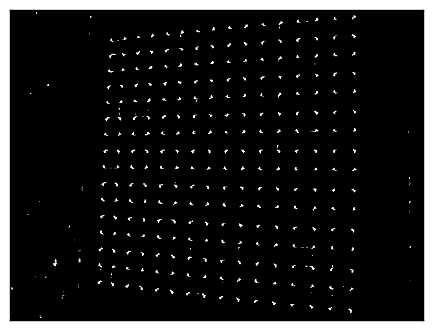

In [5]:
def mostrar(imagen):
    if len(imagen.shape) == 3:
        img = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        img = imagen
        plt.imshow(img, cmap='Greys_r')
    
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def create_binary_harris(lista_escalas, umbral):
    # y para cada escala, usamos la función de OpenCV "cornerEigenValsAndVecs" para extraer los mapas de
    # auto-valores de la matriz Harris en cada píxel. Debemos tener en cuenta que esta función devuelve
    # 6 matrices (lambda1, lambda2, x1, y1, x2, y2) donde:
    #       * lambda1, lambda2 son los autovalores de M no ordenados
    #       * x1, y1 son los autovectores de lambda1
    #       * x2, y2 son los autovectores de lambda2
    scale_eigenvalues = []  # lista de matrices en el que guardar resultados
    for escala in lista_escalas:
        scale_eigenvalues.append(cv2.cornerEigenValsAndVecs(src=escala, blockSize=3, ksize=3))

    # una vez tenemos los autovalores de cada imagen, creamos una matriz por cada escala con el criterio de harris
    matrices_harris = []  # lista de matrices para guardar las matrices del criterio de harris para cada escala
    for escala in scale_eigenvalues:
        canales = cv2.split(escala)  # cornerEigenValsAndVecs devuelve una imagen con seis canales.
        matrices_harris.append(criterio_harris(lambda1=canales[0], lambda2=canales[1]))

    # inicializamos una lista de imágenes binarias a 255 si no supera un determinado umbral y a 255 si lo supera. 
    # Una por escala.
    binaria = [binary_harris(escala, umbral) for escala in matrices_harris]

    return binaria, matrices_harris

img = cv2.imread('datos-T2/Tablero1.jpg', cv2.IMREAD_GRAYSCALE)
escalas = piramide_gaussiana(img=img, scale=3, sigma=1, return_canvas=False)
binaria, matrices_harris = create_binary_harris(lista_escalas = escalas, umbral=0.00001)
mostrar(binaria[0])

Para poder eliminar todos los _falsos máximos_ implementamos la ___supresión de no máximos locales___. En la cual recorremos la imagen binaria con una ventana, si el centro de la ventana es un píxel en blanco comprobamos si es máximo local (usando la función `is_localmax_center`), en caso positivo pintamos de negro todos los píxeles de la ventana menos el central (usando la función `put_zero_least_center`) y en caso negativo, pintamos el píxel central de negro.

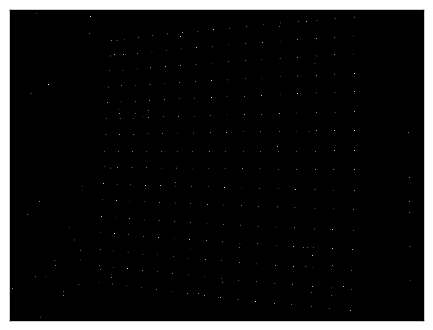

In [6]:
# función que tomando como entrada los valores de un entorno nos indica si el valor del centro es máximo local.
# Estamos presuponiendo una ventana 2D con un número impar de dimensiones (3x3, 5x5, etc)
is_localmax_center = lambda entorno: np.argmax(entorno) == floor((entorno.shape[0]*entorno.shape[1])/2)

# función que pone en negro todos los píxeles de un entorno menos el central
def put_zero_least_center(img, window_size, i, j):
    img[i-window_size:i+window_size+1, j-window_size:j+window_size+1] = 0
    img[i,j] = 255
    
def remove_local_maxima(binaria, matrices_harris, window_size, scale):
    # una vez tenemos nuestra imagen binaria, la recorremos preguntando para cada posición con valor 255 si
    # su correspondiente valor en la matriz de harris es máximo local o no.
    for escala in range(scale):
        # nos quedamos con los índices que superan el umbral
        harris_index = np.where(
            binaria[escala] == 255)  # where devuelve un vector con los índices fila y otro con las columnas
        # una vez tenemos esos indices, comprobamos si el valor de esa posición es máximo local o no
        for i in range(len(harris_index[0])):
            row = harris_index[0][i]
            col = harris_index[1][i]
            # comprobamos si el pixel row,col de la imagen binaria es máximo local
            if row >= window_size and col >= window_size and is_localmax_center(matrices_harris[escala] \
                                                                                        [
                                                                                row - window_size:row + window_size + 1,
                                                                                col - window_size:col + window_size + 1]):
                # si es máximo local, ponemos en negro a todos los píxeles de su entorno
                put_zero_least_center(binaria[escala], window_size, row, col)
            else:
                # si no lo es, ponemos el píxel a 0
                binaria[escala][row, col] = 0

remove_local_maxima(binaria=binaria, matrices_harris=matrices_harris, window_size=3, scale=1)
mostrar(binaria[0])

Si comparamos esta imagen con la anterior, se ve que hemos eliminado bastantes puntos y nos hemos quedado únicamente con los _verdaderos_ máximos, con los _puntos Harris_. 

El siguiente paso es quedarnos con los puntos que tengan un mayor valor de Harris y obviar el resto. Para ello, debemos ordenar los puntos por su valor de Harris y quedarnos con los $n$ primeros de la lista. Para poder trabajar de forma más sencilla, `numpy` nos proporciona herramientas para poder realizar filtrado y ordenación de elementos mediante sus índices.

In [7]:
def get_best_harris(matrices_harris, binaria, points_to_keep, n_points, scale):
    # una vez tenemos los puntos de Harris eliminando no máximos, los ordenamos por su valor de Harris para quedarnos con
    # los n_points mejores
    best_harris = []
    for escala in range(scale):
        # nos quedamos con los índices que corresponden con puntos de harris
        harris_index = np.where(binaria[escala] == 255)
        # y también con el valor de harris de esos puntos
        harris_points = matrices_harris[escala][harris_index]
        # obtenemos los índices de los puntos del vector harris_points ordenados
        sorted_indexes = np.argsort(harris_points)[::-1]
        # juntamos en una matriz con dos columnas las coordenadas x,y de los puntos y nos quedamos con los
        # points_to_keep[escala]*n_points primeros
        best_harris.append(np.vstack(harris_index).T[sorted_indexes[0:int(points_to_keep[escala] * n_points)]])
        binaria[escala][:] = 0
        binaria[escala][best_harris[escala][:, 0], best_harris[escala][:, 1]] = 255

    return best_harris

Una vez tenemos los mejores _puntos Harris_, los pintamos sobre la imagen para poder visualizarlos. Para ello, usamos la función `draw_circle_on_corners`.

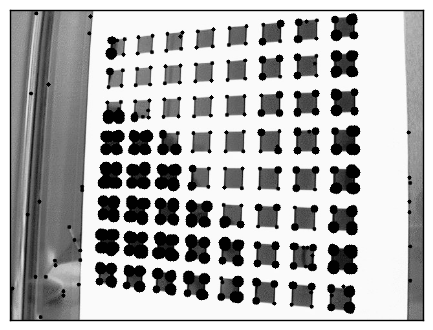

In [8]:
# función que dibuja circulos en la imagen original
def draw_circle_on_corners(img, esquinas, scale, orientaciones = None, addOrientation=False):
    img_aux = img.copy()
    # En primer lugar creamos una matriz auxiliar en la que calcular las coordenadas de todos los puntos 
    # de todas las escalas.
    best_harris_coords_orig = []  # imagen para guardar las coordenadas de harris en escala original
    best_harris_coords_orig.append(np.array(esquinas[0], dtype=np.int64))
    for escala in range(1, scale):
        # pasamos las coordenadas de la escala escala a las de la imagen original
        best_harris_coords_orig.append(np.array(esquinas[escala] * (2 * escala), dtype=np.int64))

    # dibujamos círculos en la imagen original
    for escala in range(scale):
        for indices in best_harris_coords_orig[escala]:
            cv2.circle(img=img_aux, radius=(escala+1)*scale, center=(indices[1], indices[0]), \
                       color=1, thickness=-1)

    # si el flag de añadir orientacion está activado, pintamos un radio en el punto
    if addOrientation:
        for escala in range(scale):
            radio = (escala+1)*scale
            for i in range(len(orientaciones[escala])):
                punto = best_harris_coords_orig[escala][i]
                angle = (orientaciones[escala][i]*180)/np.pi
                cv2.line(img=img_aux, pt1=(punto[1], punto[0]), pt2 = (punto[1]+floor(np.sin(angle)*radio), \
                                                                   punto[0]+floor(np.cos(angle)*radio)), color=255)

    mostrar(img_aux)
    
best_harris = get_best_harris(matrices_harris=matrices_harris, binaria=binaria, points_to_keep=[0.7, 0.2, 0.1], \
                  n_points = 1500, scale=3)
draw_circle_on_corners(img=img, esquinas=best_harris, scale=3)

Los puntos se han colocado en esquinas y sitios donde había un fuerte contraste de tonos. Por tanto, podemos concluir que hemos implementado un buen detector de puntos _Harris_.

Por tanto, la función desarrollada para este apartado es:

In [9]:
# apartado a) Calcular puntos de harris y pintarlos en la imagen original.
def Harris(lista_escalas,  umbral=0.00001, n_points = 1500, points_to_keep = [0.7, 0.2, 0.1], window_size = 1, scale = 3):
    img = lista_escalas[0]

    # Calculamos los puntos Harris que superan un determinado umbral.
    binaria, matrices_harris = create_binary_harris(lista_escalas=lista_escalas, umbral=umbral)

    # supresión de no máximos
    remove_local_maxima(binaria=binaria, matrices_harris=matrices_harris, window_size=window_size, scale=scale)

    # nos quedamos con los 1500 mejores puntos
    best_harris = get_best_harris(matrices_harris=matrices_harris, binaria=binaria, points_to_keep=points_to_keep, \
                  n_points=n_points, scale=scale)

    # una vez filtrados los mejores puntos de cada escala, los colocamos en la imagen original, dependiendo de la escala
    # tendrán un radio u otro.
    draw_circle_on_corners(img=img, esquinas=best_harris, scale=scale)

    return best_harris

Nótese que, aunque el ejemplo se ha realizado para una única escala, la función está preparada para trabajar con imágenes a múltiples escalas.

## Apartado b - Refinar la posición de los puntos a nivel de sub-píxel

Para hacer este apartado, es necesario usar la función de _OpenCV_ `cornerSubPix`. Al estar trabajando a nivel de sub-píxel, esta función necesita trabajar con datos flotantes.

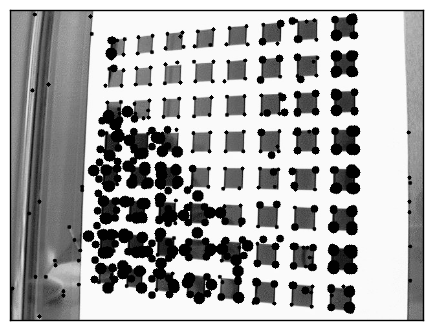

In [10]:
# Función para refinar las esquinas sacadas en el apartado a con conrnerSubPix
def refina_Harris(escalas, esquinas, scale=3):
    ref_escalas = []
    for i in range(len(escalas)):
        float_esquinas = np.array(esquinas[i], dtype=np.float32)
        cv2.cornerSubPix(image=escalas[i], corners=float_esquinas, winSize=(5,5), zeroZone=(-1,-1), \
                        criteria=(cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_COUNT, 10, 0.01))
        ref_escalas.append(float_esquinas)

    draw_circle_on_corners(img=escalas[0], esquinas=ref_escalas,scale=scale)
    return ref_escalas

esquinas_ref = refina_Harris(escalas=escalas, esquinas = best_harris, scale=3)

En este caso, debido a truncamientos a la hora de calcular el centro del círculo, hay puntos que están colocados en sitios en los que no hay ninguna esquina o un cambio brusco de color.

## Apartado c - Calcular orientación de los puntos Harris

Para calcular la orientación de un punto, debemos calcular los gradientes en $x$ y en $y$ aplicando derivadas en los ejes $x$ e $y$ de las imágenes. Para ello, aplicamos un kernel gaussiano con $\sigma = 4,5$ a la imagen en un sólo eje ($x$ o $y$). Una vez tenemos las derivadas, calculamos la orientación $\theta$ en cada punto con la siguiente fórmula:

$$ \theta_{xy} = arctan \Bigg ( \frac{grad_y}{grad_x} \Bigg) $$

El vector correspondiente a la orientación $\theta$ es $[cos(\theta), sin(\theta)]$. 

Un detalle de implementación de la función, es que sólo calculamos la arcotangente de los puntos Harris, ya que son los que nos interesan.

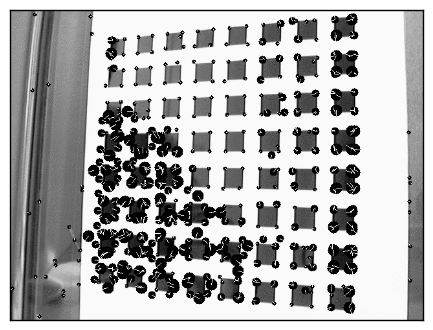

In [11]:
# Función para calcular la orientación de cada esquina encontrada.
def find_orientacion(escalas, esquinas, sigma=4.5):
    # calculamos las derivadas en x y en y aplicando un filtro sobel sobre la imagen. Una vez calculadas las derivadas,
    # calcular la arcotangente, que será la orientación del punto.
    orientaciones = []
    for i in range(len(escalas)):
        k = my_getGaussianKernel(sigma=sigma)
        esq_int = esquinas[i].T.astype(int)
        grad_x = my_filter2D(src=escalas[i], kernel=k, borderType='reflect',\
                             ejex=True, ejey=False)[esq_int[0], esq_int[1]]
        grad_y = my_filter2D(src=escalas[i], kernel=k, borderType='reflect',\
                             ejex=False, ejey=True)[esq_int[0], esq_int[1]]
        orientaciones.append(np.arctan2(grad_y, grad_x))

    draw_circle_on_corners(img=escalas[0], esquinas=esquinas, scale=3, orientaciones=orientaciones, addOrientation=True)

    return orientaciones

orientacion = find_orientacion(escalas=escalas, esquinas=esquinas_ref)

# Ejercicio 2 - Establecer correspondencias entre dos imágenes

Para ello, vamos a usar el detector de _OpenCV_ __AKAZE__. Con dicho detector, vamos a extraer una lista de `keyPoints` y un descriptor por cada imagen (en este caso sólo usaremos dos imágenes). Para poder usar el criterio de correspondencias ___BruteForce + crossCheck___, debemos usar los métodos de la clase `BFMatcher` con el flag `crossCheck` activado. Además, para calcular las distancias entre puntos usaremos la ditancia euclídea (parámetro `NORM_L2`):

$$ |x| = \sqrt{\sum_{k=1}^n |x_k|^2} $$

Con el flag `crossCheck` activado, el método `knnMatch` con $k=1$ nos devolverá las parejas $(i,j)$ tales que $i$ sea el descriptor más cercano para $j$ y viceversa. De todas las parejas que nos devuelve este método, debemos quedarnos con las $n$ mejores.

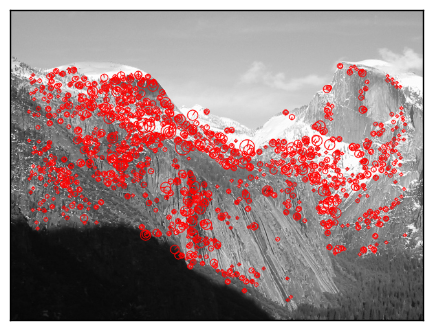

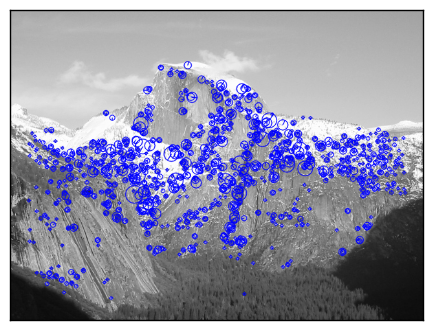

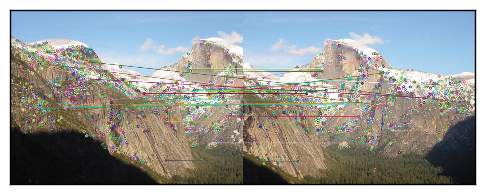

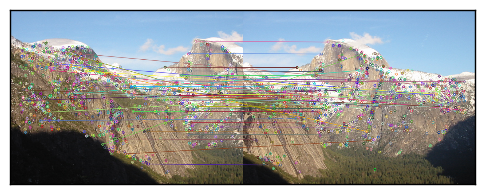

In [13]:
# Ejercicio 2
def knn_matching(bf, desc1, desc2, kps1, kps2, img1, img2, n, k=1):
    # como crossCheck es True, knnMatch con k = 1 nos devolverá las parejas (i,j) tales que el vecino más cercano de i
    # sea j y viceversa
    # (FUENTE: http://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_descriptor_matchers.html)
    matches = bf.knnMatch(desc1, desc2, k=k)

    # tomamos n aleatorios para dibujarlos
    indices = sample(range(len(kps2)), n)

    matches_img = cv2.drawMatchesKnn(img1=img1, keypoints1=kps1, img2=img2, keypoints2=kps2, \
                                     matches1to2=[matches[i] for i in indices], outImg=None)
    mostrar(matches_img)

def normal_matching(bf, desc1, desc2, kps1, kps2, img1, img2, n, mostrar_img):
    matches = np.array(bf.match(desc1, desc2))

    if mostrar_img:
        # tomamos n aleatorios para dibujarlos
        indices = sample(range(len(matches)), n)

        # dibujamos los n primeros
        matches_img = cv2.drawMatches(img1=img1, keypoints1=kps1, img2=img2, keypoints2=kps2, \
                                         matches1to2=[matches[i] for i in indices], outImg=None)
        mostrar(matches_img)

    return matches

def akaze_match(img1, img2, mask=None, mostrar_img=True, n=50):
    # pasamos las fotos a blanco y negro
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # inicializamos el descriptor AKAZE
    detector = cv2.AKAZE_create()

    # detectamos los keypoint y extraemos los descriptores de ambas fotos.
    kps1, descs1 = detector.detectAndCompute(image=gray1, mask=mask)
    kps2, descs2 = detector.detectAndCompute(image=gray2, mask=mask)

    if mostrar_img:
        # dibujamos los puntos claves en la imagen 1
        keypoints_img1 = cv2.drawKeypoints(image=gray1, keypoints=kps1, outImage=None, color=(0,0,255),
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        mostrar(keypoints_img1)
        # y en la imagen 2
        keypoints_img2 = cv2.drawKeypoints(image=gray2, keypoints=kps2, outImage=None, color=(255, 0, 0),
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        mostrar(keypoints_img2)

    # para hacer el matching, usamos la fuerza bruta y validación cruzada, NORM_L2 es la distancia euclídea.
    # (FUENTE: http://stackoverflow.com/questions/32849465/difference-between-cv2-norm-l2-and-cv2-norm-l1-in-opencv-python#32849908)
    bf = cv2.BFMatcher(normType=cv2.NORM_L2, crossCheck=True)

    # hacemos el matching usando knn
    if mostrar_img:
        knn_matching(bf=bf, desc1=descs1, desc2=descs2, kps1=kps1, kps2=kps2, img1=img1, img2=img2, n=n)

    # hacemos el matching usando el método match
    matches = normal_matching(bf=bf, desc1=descs1, desc2=descs2, kps1=kps1, kps2=kps2, img1=img1, img2=img2,
                              n=n, mostrar_img=mostrar_img)

    return matches, kps1, kps2
    
img1 = cv2.imread('datos-T2/yosemite/Yosemite1.jpg', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('datos-T2/yosemite/Yosemite2.jpg', cv2.IMREAD_UNCHANGED)
matches, kps1, kps2 = akaze_match(img1=img1, img2=img2)

Como se ve, algunas correspondencias sí que son correctas, en cambio, también ha hecho correspondencias con puntos de una imagen que no aparecen en la otra y por tanto, son erróneos. Esto se debe a que las zonas en las que se ha hecho la correspondencia errónea son muy similares entre sí.

En general, vemos que hay líneas rectas pero también líneas en otras direcciones. Este es el resultado que esperábamos, ya que es imposible que este método calcule las correspondencias correctamente al 100%. Además, he hecho las correspondencias usando dos métodos para compararlos entre sí: `knnMatch` y `match`, con ambas obtengo un resultado prácticamente idéntico.

# Ejercicio 3 - Crear un mosaico
## Apartado a - Crear un mosaico con dos imágenes

Para crear un mosaico entre dos imágnenes me apoyo principalmente en dos funciones de _OpenCV_: `findHomography` y `warpPerspective`. La primera la uso para calcular la homografía con la que relaciono ambas imágenes y la segunda, para transformar la segunda imagen (usando la homografía $H$ calculada anteriormente) de forma que pueda encajar con la primera en el plano del mosaico.

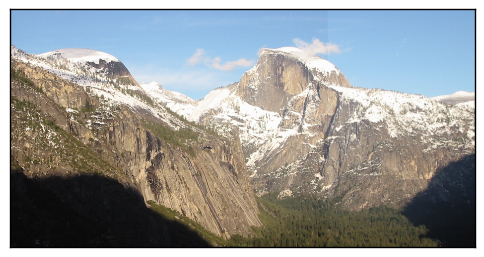

In [22]:
def mosaico_dos(img1, img2, epsilon=0.5, mostrar_img=True):
    matches, kps1, kps2 = akaze_match(img1=img1, img2=img2, mask=None, mostrar_img=False)
    puntos_dst = np.float32([kps1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    puntos_src = np.float32([kps2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    homografia, mascara = cv2.findHomography(srcPoints=puntos_src, dstPoints=puntos_dst, method=cv2.RANSAC,
                                            ransacReprojThreshold=epsilon)
    result = cv2.warpPerspective(src=img2, M=homografia, dsize=(img1.shape[1] + img2.shape[1], img2.shape[0]))
    result[0:img1.shape[0], 0:img1.shape[1]] = img1
    result=np.delete(arr=result, obj=np.where(result==0)[1],axis=1)
    if mostrar_img:
        mostrar(result)

    return result

img1 = cv2.imread('datos-T2/yosemite/Yosemite1.jpg', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('datos-T2/yosemite/Yosemite2.jpg', cv2.IMREAD_UNCHANGED)
mosaico_d = mosaico_dos(img1=img1, img2=img2)

Como se ve en la imagen, el mosaico obtenido encaja perfectamente y lo único que puede resultar extraño es el cambio en el azul del cielo: en la primera imagen el color es más intenso que en la segunda. Para corregir esto tendríamos que hacer un __degradado entre ambos azules__ de forma que el cambio no fuese tan brusco y no resultase tan extraño al ojo.

## Apartado b - Mosaico entre $n$ imágenes

Para calcular un mosaico entre varias imágenes, he decidido aprovechar la función que he hecho para hacerlo entre dos. Mi función funciona de la siguiente manera: en primer lugar divido la lista de imágenes en dos, y ___recursivamente___, hago un mosaico de cada una de las mitades de la lista de imágenes. Esto lo hago para obtener la menor deformación posible en la imagen final. Si empezase a hacer mosaicos por uno de los extremos de la lista, el extremo contrario quedaría totalmente deformado y obtendríamos un mosaico _estéticamente más feo_.

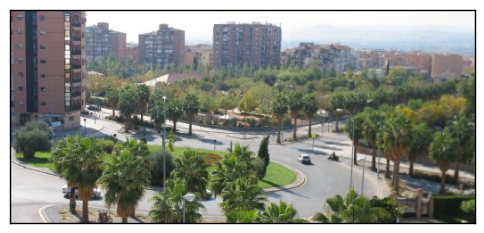

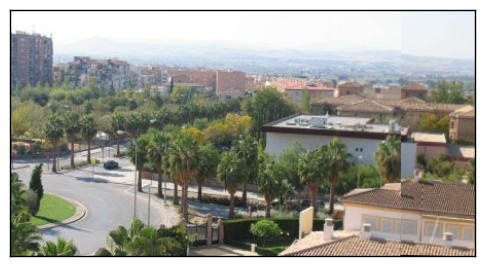

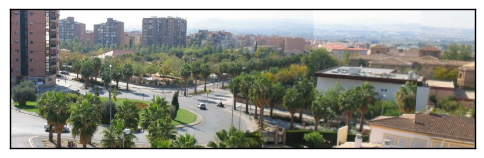

In [19]:
# mosaico con más de dos imágenes asumiendo que las pasamos al programa en orden
def mosaico_n(lista_imagenes):
    if len(lista_imagenes) == 3:
        # hacemos un mosaico con las dos primeras imagenes
        mosaico_12 = mosaico_dos(img1 = lista_imagenes[0], img2=lista_imagenes[1], mostrar_img=False)
        mosaico_23 = mosaico_dos(img1 = lista_imagenes[1], img2=lista_imagenes[2], mostrar_img=False)
        # y los unimos
        return mosaico_dos(img1=mosaico_12, img2=mosaico_23, mostrar_img=False)

    elif len(lista_imagenes) == 2:
        return mosaico_dos(img1=lista_imagenes[0], img2=lista_imagenes[1], mostrar_img=False)

    else:
        # nos quedamos con el índice de la imagen central
        central = floor(len(lista_imagenes)/2)
        # llamamos recursivamente a esta función con dos listas
        mosaico_primeramitad = mosaico_n(lista_imagenes[:central])
        mosaico_segundamitad = mosaico_n(lista_imagenes[central:])
        # y hacemos un mosaico con ambas
        mosaico = mosaico_dos(img1=mosaico_primeramitad, img2=mosaico_segundamitad, mostrar_img=False)

        mostrar(mosaico)

        return mosaico

img1 = cv2.imread('datos-T2/mosaico-1/mosaico002.jpg', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('datos-T2/mosaico-1/mosaico003.jpg', cv2.IMREAD_UNCHANGED)
img3 = cv2.imread('datos-T2/mosaico-1/mosaico004.jpg', cv2.IMREAD_UNCHANGED)
img4 = cv2.imread('datos-T2/mosaico-1/mosaico005.jpg', cv2.IMREAD_UNCHANGED)
img5 = cv2.imread('datos-T2/mosaico-1/mosaico006.jpg', cv2.IMREAD_UNCHANGED)
img6 = cv2.imread('datos-T2/mosaico-1/mosaico007.jpg', cv2.IMREAD_UNCHANGED)
img7 = cv2.imread('datos-T2/mosaico-1/mosaico008.jpg', cv2.IMREAD_UNCHANGED)
img8 = cv2.imread('datos-T2/mosaico-1/mosaico009.jpg', cv2.IMREAD_UNCHANGED)
img9 = cv2.imread('datos-T2/mosaico-1/mosaico010.jpg', cv2.IMREAD_UNCHANGED)
img10 = cv2.imread('datos-T2/mosaico-1/mosaico011.jpg', cv2.IMREAD_UNCHANGED)
mosaico_nimg = mosaico_n(lista_imagenes=[img1,img2,img3,img4,img5,img6,img7,img8,img9,img10])

La calidad _general_ del mosaico obtenido es muy buena. Sin embargo, en la segunda mitad del mosaico vemos que la última imagen no se ha acoplado bien del todo. Esto se debe a que entre la imagen _mosaico009.jpg_ y _mosaico010.jpg_ hay un cambio de altura y la homografía entre estas dos imágenes no se ha calculado correctamente. 

Además, no se ve en el mosaico toda la imagen _mosaico011.jpg_ debido a que la altura del mosaico es  la misma que la altura de la primera imagen y además, se recorta toda la parte en negro.